$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

# Examples of using pyCCE code

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# Install a pip package in the current Jupyter kernel
import sys
sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
import pycce as pc
# !{sys.executable} -m pip install --user ase
# !{sys.executable} -m pip install --user numpy --upgrade

import ase

np.random.seed(42055)
np.set_printoptions(suppress=True, precision=5)

# NV Center in Diamond
An example of computing Hahn-echo coherence function using all three available methods: 
* Conventional CCE
* Generalized CCE
* Generalized CCE with Monte-Carlo bath sampling (gCCE)

### Generate nuclear spin bath
Building a supercell of nuclear spins from the `ase.Atoms` object.

In [9]:
from ase.build import bulk

# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.bath.BathCell.from_ase(diamond)
# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
# set z direction of the defect
diamond.zdir = [1, 1, 1]
# Generate supercell
                              # Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]))

### CCE Simulator
Setting the parameters of CCE engine

In [10]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
CCE_order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole moment (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]

# Setting the runner engine
calc = pc.Simulator(spin=1, position=position, alpha=alpha, beta=beta,
                    types=spin_types,
                    bath=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)

nspin = calc.bath
# Set model quadrupole tensor at N atom
nspin['Q'][nspin['N'] == '14N'] = np.asarray([[-2.5, 0, 0],
                                              [0, -2.5, 0],
                                              [0, 0,  5.0]]) * 1e3 * 2 * np.pi

### Compute coherence function with conventional CCE

In [11]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 100])  # in G

Lconv = calc.compute_coherence(time_space, B, N, as_delay=False)

### Generalized CCE

In [12]:
# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 * 2 * np.pi # in kHz * rad
E = 0 # in kHz * rad
# Hahn-echo pulse sequence
pulse_sequence = [('x', np.pi)]

# Calculate all elements of the density matrix and extract coherence function
dms = calc.compute_dmatrix(time_space, B, D, E, pulse_sequence)
Lgen = np.einsum('a,iab,b->i', calc.alpha, dms, calc.beta)
Lgen = Lgen/Lgen[0]

### Generalized CCE with random sampling of bath states (gCCE)

In [13]:
# Number of random bath states to sample over
n_bath_states = 100

# Calculate all elements of the density matrix and extract coherence function
meanfield_dms = calc.compute_mf_dm(time_space, B, D, E, pulse_sequence, nbstates=n_bath_states)
Lmf = np.einsum('a,iab,b->i', calc.alpha, meanfield_dms, calc.beta)
Lmf = Lmf / Lmf[0]

Plot all of the results and check that they produce similar results

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'L')

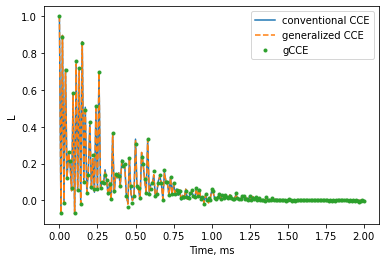

In [15]:
plt.plot(time_space, Lconv, label='conventional CCE')
plt.plot(time_space, Lgen, label='generalized CCE', ls='--')
plt.plot(time_space, Lmf, label='gCCE', ls='', marker='.')

plt.legend()
plt.xlabel('Time, ms')
plt.ylabel('L')

# VV in SiC
An example of computing FID with GIPAW computed A

In [16]:
# Set up unit cell with (a, b, c, alpha, beta, gamma)
sic = pc.bath.BathCell(3.073, 3.073, 10.053, 90, 90, 120, 'deg')
# z axis in cell coordinates
sic.zdir = [0, 0, 1]
# position of atoms
sic.add_atoms(('Si', [0.00000000, 0.00000000, 0.1880]),
              ('Si', [0.00000000, 0.00000000, 0.6880]),
              ('Si', [0.33333333, 0.66666667, 0.4380]),
              ('Si', [0.66666667, 0.33333333, 0.9380]),
              ('C', [0.00000000, 0.00000000, 0.0000]),
              ('C', [0.00000000, 0.00000000, 0.5000]),
              ('C', [0.33333333, 0.66666667, 0.2500]),
              ('C', [0.66666667, 0.33333333, 0.7500]))
# isotopes 
sic.add_isotopes(('29Si', 0.047), ('13C', 0.011))

# defect position in cell units
vsi_cell = [0, 0, 0.1880]
vc_cell = [0, 0, 0]

# Generate bath spin positions
atoms = sic.gen_supercell(200, remove=[('Si', vsi_cell),
                                       ('C', vc_cell)])

## Read Quntum Espresso output

In [19]:
# Prepare rotation matrix to alling with z axis of generated atoms
# This matrix, acting on the [0, 0, 1] in Cartesian coordinates of GIPAW output
# Should produce [a, b, c] vector, alligned with zdirection of the NSpinCell
M = np.array([[0, 0, -1],
              [0, -1, 0],
              [-1, 0, 0]])

# Cell coordinates to change coordinates in exatoms from cell to cartesian
cell = np.array([[20.272033, 0.000000, 0.000000],
                 [0.000000, 26.811944, 0.000000],
                 [0.000000, 0.000000, 27.863846]])

# Position of (0,0,0) point in cell coordinates
center = [0.6, 0.5, 0.5]
# Read GIPAW results
exatoms = pc.bath.read_qe('gipaw/pw.in',
                          hyperfine='gipaw/gipaw.out',
                          center=center, rotation_matrix=M, rm_style='row',
                          which_isotopes={'C':'13C', 'Si':'29Si'})

In [20]:
# Check the types of nuclear spins
exatoms.types

SpinDict({'13C': (13C, 0.5, 6.7283, 0), '29Si': (29Si, 0.5, -5.3188, 0)})

In [31]:
# Setting up CCE calculations
pos = sic.to_cartesian(vsi_cell)
N = 0
CCE_order = 2
r_bath = 40
r_dipole = 8
time_space = np.linspace(0, 0.01, 501)

B = np.array([0, 0, 500])
calc = pc.Simulator(1, pos, [0, 0, 1], [0, 1, 0])
# Separately read bath
calc.read_bath(atoms, r_bath,
               external_bath=exatoms)
calc.generate_clusters(CCE_order, r_dipole=r_dipole);

In [32]:
Lsic = calc.compute_coherence(time_space, B, N, as_delay=False)

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'L')

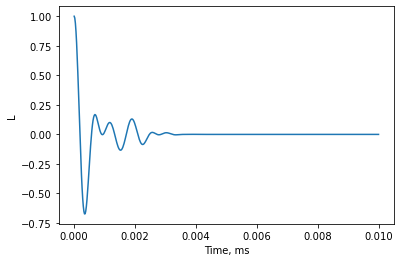

In [33]:
plt.plot(time_space, Lsic)
plt.xlabel('Time, ms')
plt.ylabel('L')

# Si
Comparison between point dipole and shallow hyperfine

In [44]:
from ase.build import bulk

# Generate unitcell from ase
s = bulk('Si', cubic=True)
s = pc.bath.BathCell.from_ase(s)
# Add types of isotopes
s.add_isotopes(('29Si', 0.047))
# set z direction of the defect
s.zdir = [1, 1, 1]
# Generate supercell
atoms = s.gen_supercell(200, remove=[('Si', [0., 0., 0.])])

In [45]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
CCE_order = 2
# Bath cutoff radius
r_bath = 60  # in A
# Cluster cutoff radius
r_dipole = 10  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0,1]; beta = [1,0]

# Setting the runner engine
calc = pc.Simulator(spin=1/2, position=position, alpha=alpha, beta=beta,
                    bath=atoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)

In [46]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
N = 1
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 1000])  # in G

Lsi_pd = calc.compute_coherence(time_space, B, N, as_delay=False)

### Hyperfines of the shallow donor

In [47]:
# PHYSICAL REVIEW B 68, 115322 (2003)
n = 0.81
a = 25.09

def factor(x, y, z, n=0.81, a=25.09, b=14.43):
    top = np.exp(-np.sqrt(x**2/(n*b)**2 + (y**2 + z**2)/(n*a)**2))
    bottom = np.sqrt(np.pi * (n * a)**2 * (n * b) )

    return top / bottom

def contact_si(r, gamma_n, gamma_e=pc.ELECTRON_GYRO, a_lattice=5.43, nu=186, n=0.81, a=25.09, b=14.43):
    k0 = 0.85 * 2 * np.pi / a_lattice
    pre = 16 * np.pi / 9 * gamma_n * gamma_e * pc.HBAR * nu
    xpart = factor(r[0], r[1], r[2], n=n, a=a, b=b) * np.cos(k0 * r[0])
    ypart = factor(r[1], r[2], r[0], n=n, a=a, b=b) * np.cos(k0 * r[1])
    zpart = factor(r[2], r[0], r[1], n=n, a=a, b=b) * np.cos(k0 * r[2])
    return pre * (xpart + ypart + zpart) ** 2

In [52]:
newatoms = atoms.copy()

# Generate hyperfine from point dipole
newatoms.from_point_dipole(np.array([0,0,0]))

# Following PRB paper
newatoms['A'][newatoms.dist() < n*a] = 0
newatoms['A'] += np.eye(3)[np.newaxis,:,:] * contact_si(newatoms['xyz'].T, newatoms.types['29Si'].gyro)[:,np.newaxis, np.newaxis] 

In [53]:
calc = pc.Simulator(spin=1/2, position=position, alpha=alpha, beta=beta,
                    bath=newatoms, r_bath=r_bath,
                    r_dipole=r_dipole, order=CCE_order)

Lsi_shallow = calc.compute_coherence(time_space, B, N, as_delay=False)

/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'L')

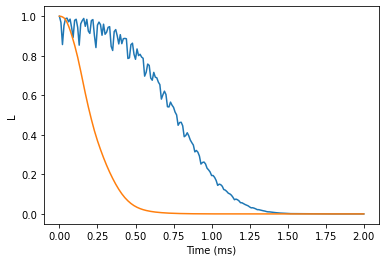

In [55]:
plt.plot(time_space, Lsi_pd)
plt.plot(time_space, Lsi_shallow)
plt.xlabel('Time (ms)')
plt.ylabel('L')